### Make sure you've already declared your API Key in the terminal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [70]:
!pip install statsmodels

     |████████████████████████████████| 10.5MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 235kB 1.7MB/s eta 0:00:01


### Define your API endpoint and database name

In [6]:
endpoint="https://api.treasuredata.com/"
database = "dilyan_ml_hivemall_test"

### Connect pandas TD 

In [7]:
import os
import pandas_td as td
con = td.connect(apikey=os.environ['TD_API_KEY'], endpoint=endpoint)

#instantiate Presto and Hive Engines
presto = td.create_engine('presto:' + database, con=con)
hive = td.create_engine('hive:' + database, con=con)

### Create a df for your original table

In [9]:
df_history = td.read_td_table('purchase_history', presto)
df_history.head()

,id,day_of_week,gender,price,category,label,time
0,5,Wednesday,female,100,electronics,1,1566322692
1,4,Thursday,male,20,food,0,1566322692
2,3,Friday,other,1800,entertainment,0,1566322692
3,2,Friday,female,480,sports,0,1566322692
4,1,Saturday,male,60,book,1,1566322692


In [12]:
df_features = df_history[['day_of_week', 'gender', 'category','price']]

In [13]:
df_features.head()

,day_of_week,gender,category,price
0,Wednesday,female,electronics,100
1,Thursday,male,food,20
2,Friday,other,entertainment,1800
3,Friday,female,sports,480
4,Saturday,male,book,60


In [14]:
df_target = df_history.label

In [16]:
df_target.head()

0    1
1    0
2    0
3    0
4    1
Name: label, dtype: int64

### Convert categorical features into dummies

In [22]:
df_processed = pd.get_dummies(df_features, drop_first=True)

In [23]:
df_processed.head()

,price,day_of_week_Saturday,day_of_week_Thursday,day_of_week_Wednesday,gender_male,gender_other,category_electronics,category_entertainment,category_food,category_sports
0,100,0,0,1,0,0,1,0,0,0
1,20,0,1,0,1,0,0,0,1,0
2,1800,0,0,0,0,1,0,1,0,0
3,480,0,0,0,0,0,0,0,0,1
4,60,1,0,0,1,0,0,0,0,0


### Check for numerical correlations

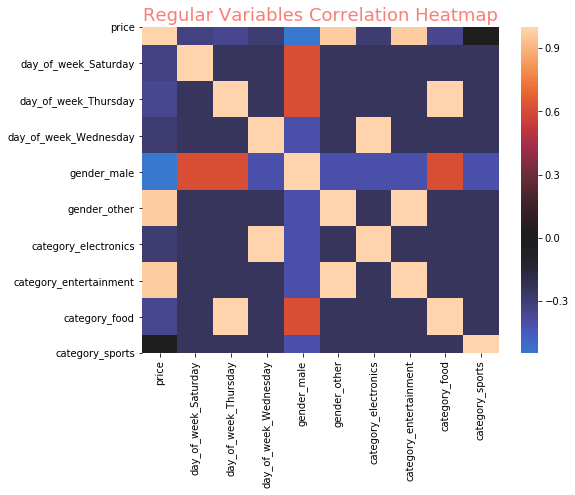

In [25]:
import seaborn as sns
plt.figure(figsize = (8,6))
plt.title("Regular Variables Correlation Heatmap", fontsize = 18, color = "#F97E77")
sns.heatmap(df_processed.corr(), center = 0)

### Change price to float jsut for fun to use .map(lambda) function

In [29]:
df_processed.price = df_processed.price.map(lambda x: float(x))
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
price                     5 non-null float64
day_of_week_Saturday      5 non-null uint8
day_of_week_Thursday      5 non-null uint8
day_of_week_Wednesday     5 non-null uint8
gender_male               5 non-null uint8
gender_other              5 non-null uint8
category_electronics      5 non-null uint8
category_entertainment    5 non-null uint8
category_food             5 non-null uint8
category_sports           5 non-null uint8
dtypes: float64(1), uint8(9)
memory usage: 213.0 bytes


### Do EDA vs pairplot on the numerical data

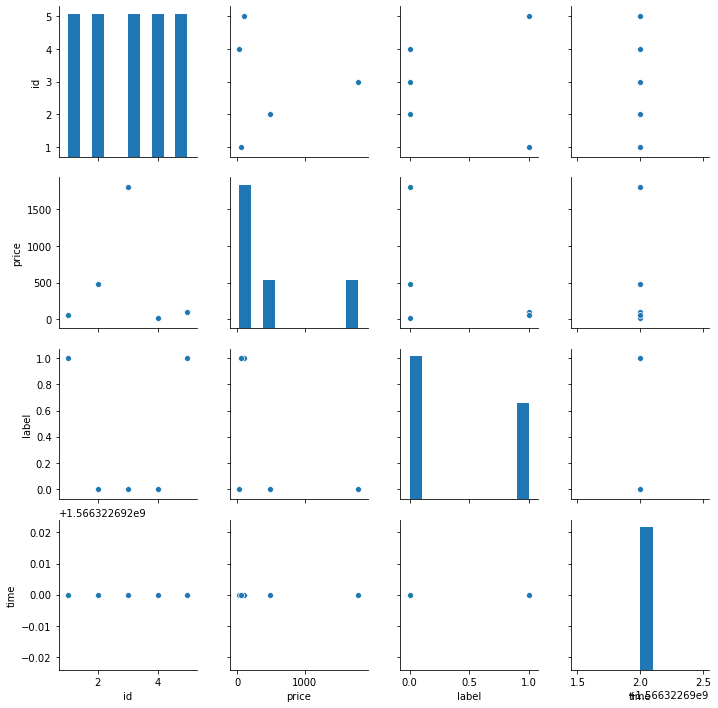

In [36]:
sns.pairplot(df_history)

### Create Plynomial Features to test performance

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import scale


poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_poly = pd.DataFrame(poly.fit_transform(df_processed), columns=poly.get_feature_names(df_processed.columns))

X_poly = features_poly

In [39]:
X_poly.head()

,price,day_of_week_Saturday,day_of_week_Thursday,day_of_week_Wednesday,gender_male,gender_other,category_electronics,category_entertainment,category_food,category_sports,...,category_electronics^2,category_electronics category_entertainment,category_electronics category_food,category_electronics category_sports,category_entertainment^2,category_entertainment category_food,category_entertainment category_sports,category_food^2,category_food category_sports,category_sports^2
0,100.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1800.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,60.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check for multicolinearity of the Plynomial Variables

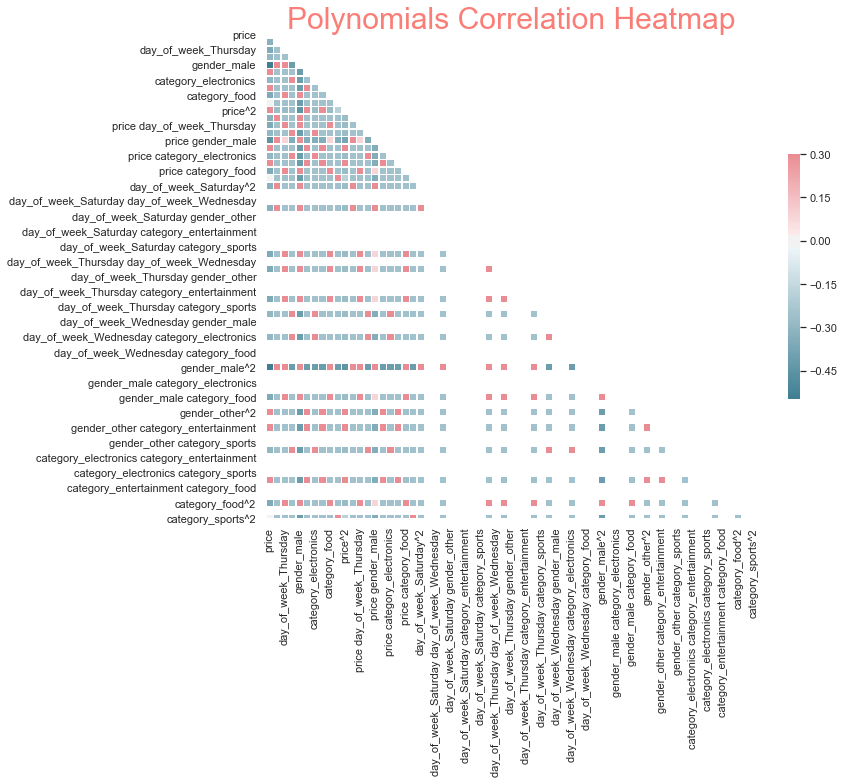

In [40]:
sns.set(style="white")


# Compute the correlation matrix
corr = features_poly.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title("Polynomials Correlation Heatmap", fontsize = 30, color = "#F97E77")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Drop any value with corr > 0.95

In [41]:
# Create correlation matrix
corr_matrix = features_poly.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Drop variables from table
X_poly.drop(columns=to_drop, inplace=True)
X_poly.shape

(5, 37)

## Define your X and y

In [30]:
X, y = df_processed, df_target

### Apply RFE to select best features combo

In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

### Try no RFE

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, 
                                                            random_state = 18,  test_size=.20)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)


/Users/dilyankovachev/Desktop/Projects/PyTD/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0

In [63]:
coef_weights = list(zip(X_poly.columns, logreg.coef_[0]))

In [67]:
coef_weights = [item for item in coef_weights if item[1] != 0]

<BarContainer object of 6 artists>

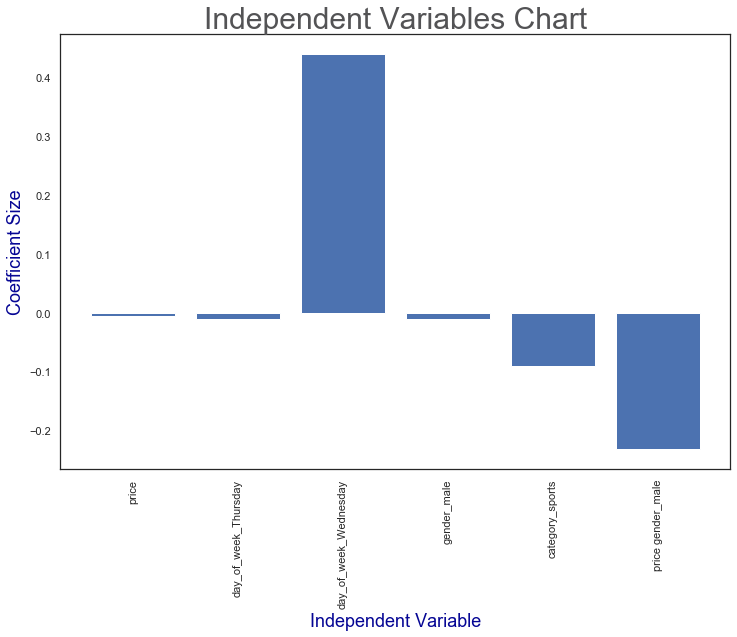

In [68]:
coefs = [item[1] for item in coef_weights]
varias = [item[0] for item in coef_weights]
plt.figure(figsize = (12,8))
plt.title("Independent Variables Chart", fontsize = 30, color = "#535355")
plt.xlabel("Independent Variable", fontsize = 18, color = "#050594")
plt.ylabel("Coefficient Size", fontsize = 18, color = "#050594")
plt.xticks(rotation=90)
plt.bar(varias, coefs)

### Look at p-values

In [71]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X_poly)
result=logit_model.fit()
print(result.summary2())

PerfectSeparationError: Perfect separation detected, results not available

## Train basic model

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/dilyankovachev/Desktop/Projects/PyTD/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### predictions + accuracy

In [73]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.50


### Confusion matrix

In [84]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1 0]
 [1 0]]


In [82]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [85]:
labels = ['True', 'False']        
print_cm(confusion_matrix, labels)

     t/p   True False 
     True   1.0   0.0 
    False   1.0   0.0 


In [86]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


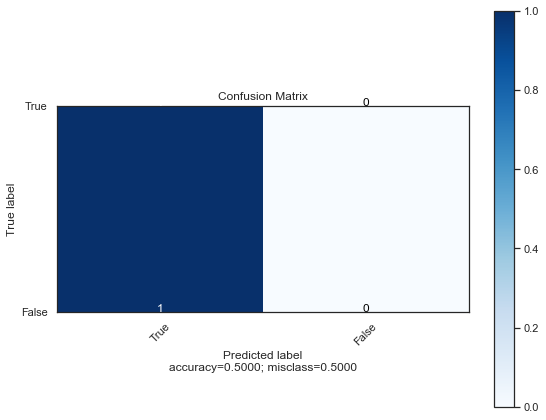

In [87]:
plot_confusion_matrix(cm = confusion_matrix, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/Users/dilyankovachev/Desktop/Projects/PyTD/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## ROC Curve

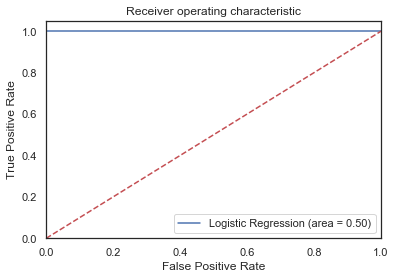

In [88]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [94]:
logreg.predict_proba(X_test)

array([[9.99992251e-01, 7.74884251e-06],
       [6.44941899e-01, 3.55058101e-01]])